In [1]:
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
import os

# Check we're in the right place
print("Current directory:", os.getcwd())
print("Imports successful")

Current directory: /Users/marshequila/Desktop/nn/grp2-quartet-chord-classification/notebooks
Imports successful


In [2]:
# Load MIDI file
midi_file = '../data/raw/quartet_1_1_(c)edwards.mid'  # Adjust filename if needed

try:
    midi = pretty_midi.PrettyMIDI(midi_file)
    print(f"Loaded MIDI file: {midi_file}")
    print(f"Duration: {midi.get_end_time():.2f} seconds")
except Exception as e:
    print(f"Error: {e}")
    print("Make sure you have a MIDI file in data/raw/")

Loaded MIDI file: ../data/raw/quartet_1_1_(c)edwards.mid
Duration: 490.16 seconds


In [3]:
# See what instruments are in the file
print(f"Number of instruments: {len(midi.instruments)}")
print("\nInstruments:")
for i, instrument in enumerate(midi.instruments):
    print(f"  {i}: {instrument.name} (program: {instrument.program})")
    print(f"     Notes: {len(instrument.notes)}")

Number of instruments: 4

Instruments:
  0: Violino I. (program: 0)
     Notes: 1916
  1: Violino II. (program: 0)
     Notes: 1765
  2: Viola. (program: 0)
     Notes: 1434
  3: Violoncello. (program: 0)
     Notes: 985


In [4]:
# Get first instrument
first_instrument = midi.instruments[0]

print(f"First 10 notes from {first_instrument.name}:")
print(f"{'Pitch':<6} {'Start':<8} {'End':<8} {'Duration':<10} {'Note Name'}")
print("-" * 50)

for note in first_instrument.notes[:10]:
    note_name = pretty_midi.note_number_to_name(note.pitch)
    duration = note.end - note.start
    print(f"{note.pitch:<6} {note.start:<8.2f} {note.end:<8.2f} {duration:<10.2f} {note_name}")

First 10 notes from Violino I.:
Pitch  Start    End      Duration   Note Name
--------------------------------------------------
65     0.00     0.57     0.57       F4
67     0.57     0.66     0.09       G4
65     0.66     0.76     0.09       F4
64     0.76     0.82     0.06       E4
65     0.95     1.01     0.06       F4
60     1.14     1.46     0.32       C4
65     2.28     2.85     0.57       F4
67     2.85     2.94     0.09       G4
65     2.94     3.03     0.09       F4
64     3.04     3.10     0.06       E4


In [5]:
def get_notes_at_time(instrument, time_point):
    """Get all notes playing at a specific time"""
    active_notes = []
    for note in instrument.notes:
        if note.start <= time_point < note.end:
            active_notes.append(note.pitch)
    return active_notes

# Pick a time point 
time_point = 0.57

print(f"Notes at time {time_point}s:")
print("-" * 40)

all_notes = []
for i, instrument in enumerate(midi.instruments[:4]):  # First 4 instruments
    notes = get_notes_at_time(instrument, time_point)
    inst_name = instrument.name if instrument.name else f"Instrument {i}"
    print(f"{inst_name}: {notes}")
    if notes:
        note_names = [pretty_midi.note_number_to_name(n) for n in notes]
        print(f"  ({', '.join(note_names)})")
    all_notes.extend(notes)

print(f"\nAll notes at this moment: {all_notes}")

Notes at time 0.57s:
----------------------------------------
Violino I.: [67]
  (G4)
Violino II.: []
Viola.: [55]
  (G3)
Violoncello.: []

All notes at this moment: [67, 55]


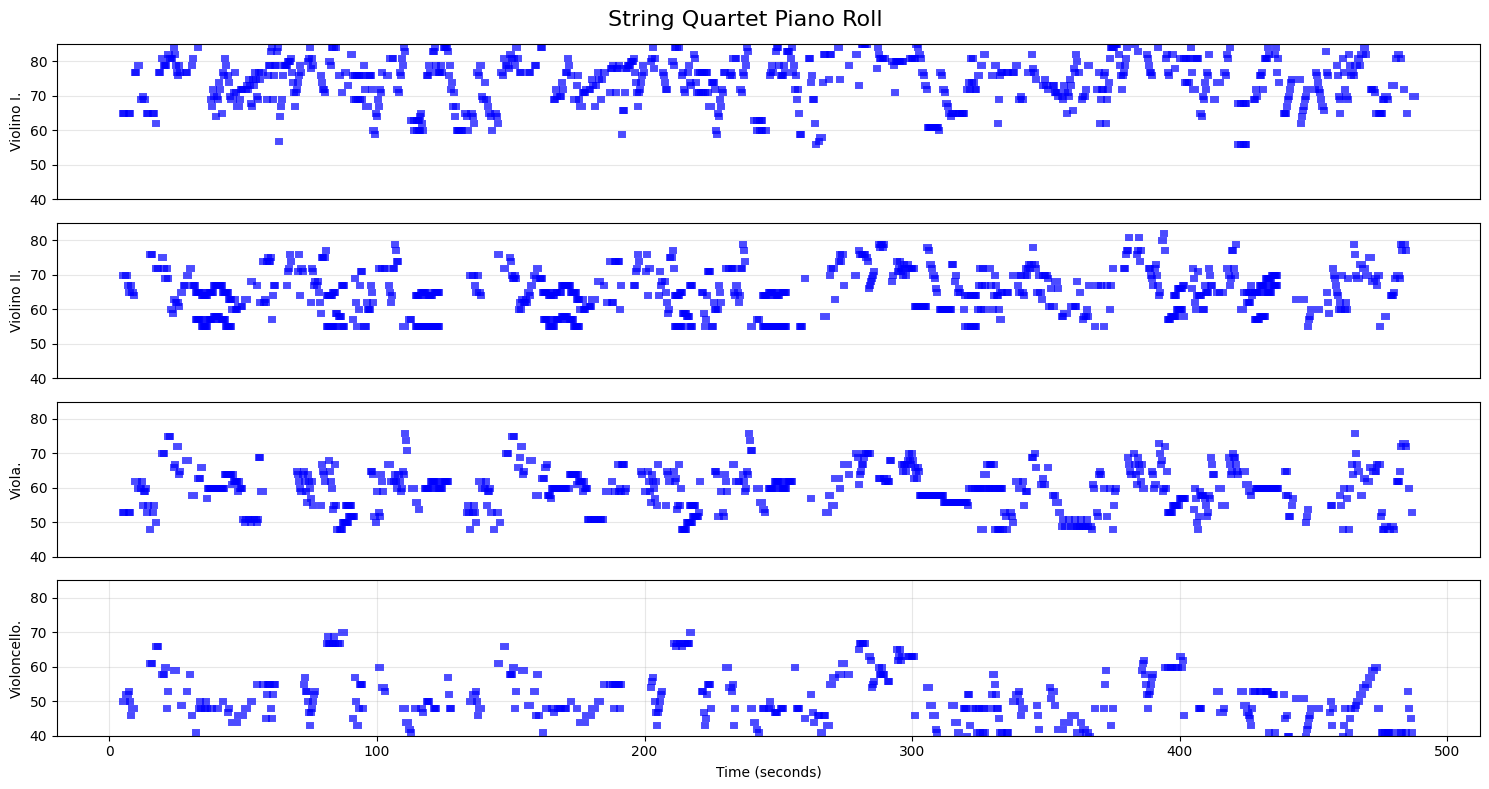

In [6]:
# Create piano roll (notes over time)
fig, axes = plt.subplots(4, 1, figsize=(15, 8))

for i, instrument in enumerate(midi.instruments[:4]):
    ax = axes[i]
    
    # Plot each note as a horizontal line
    for note in instrument.notes:
        ax.plot([note.start, note.end], [note.pitch, note.pitch], 
                linewidth=5, color='blue', alpha=0.7)
    
    inst_name = instrument.name if instrument.name else f"Instrument {i+1}"
    ax.set_ylabel(inst_name)
    ax.set_ylim(40, 85)  # Typical range for string quartet
    ax.grid(True, alpha=0.3)
    
    if i < 3:
        ax.set_xticks([])
    else:
        ax.set_xlabel('Time (seconds)')

plt.suptitle('String Quartet Piano Roll', fontsize=16)
plt.tight_layout()
plt.show()


In [7]:
def classify_chord_simple(notes):
    """Simple chord classifier"""
    if len(notes) < 3:
        return "Incomplete chord"
    
    # Get unique pitch classes (0-11)
    pitch_classes = sorted(set([n % 12 for n in notes]))
    
    # Calculate intervals from root
    root = min(notes) % 12
    intervals = tuple(sorted([(pc - root) % 12 for pc in pitch_classes]))
    
    # Simple chord dictionary
    chord_types = {
        (0, 4, 7): "Major",
        (0, 3, 7): "minor",
        (0, 3, 6): "diminished",
        (0, 4, 8): "augmented",
    }
    
    chord_quality = chord_types.get(intervals, "Unknown")
    
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    root_name = note_names[root]
    
    return f"{root_name} {chord_quality}"

# Sample several time points
print("Chord progression:")
print("-" * 60)

time_points = [0, 0.5, 1.0, 1.5, 2.0, 2.5]

for t in time_points:
    if t >= midi.get_end_time():
        break
    
    # Get notes from all instruments
    all_notes = []
    for instrument in midi.instruments[:4]:
        notes = get_notes_at_time(instrument, t)
        all_notes.extend(notes)
    
    if all_notes:
        chord = classify_chord_simple(all_notes)
        note_names = [pretty_midi.note_number_to_name(n) for n in sorted(all_notes)]
        print(f"Time {t:.1f}s: {chord:20} - Notes: {', '.join(note_names)}")

Chord progression:
------------------------------------------------------------
Time 0.0s: Incomplete chord     - Notes: F3, F4
Time 0.5s: Incomplete chord     - Notes: F3, F4
Time 1.0s: Incomplete chord     - Notes: F3, F4
Time 2.5s: Incomplete chord     - Notes: F3, F4


In [8]:
def extract_all_chords(midi, beat_duration=0.5):
    """Extract chords at regular intervals"""
    duration = midi.get_end_time()
    num_beats = int(duration / beat_duration)
    
    chords = []
    
    for beat_num in range(num_beats):
        beat_time = beat_num * beat_duration
        
        # Get notes from all 4 instruments
        all_notes = []
        for instrument in midi.instruments[:4]:
            notes = get_notes_at_time(instrument, beat_time)
            all_notes.extend(notes)
        
        if len(all_notes) >= 3:
            chord_label = classify_chord_simple(all_notes)
            chords.append({
                'time': beat_time,
                'notes': all_notes,
                'label': chord_label
            })
    
    return chords

# Extract all chords
chords = extract_all_chords(midi)

print(f"Extracted {len(chords)} chords")
print("\nFirst 10 chords:")
for i, chord in enumerate(chords[:10]):
    print(f"{i+1}. Time {chord['time']:.1f}s: {chord['label']:20} {chord['notes']}")

Extracted 599 chords

First 10 chords:
1. Time 5.0s: D Unknown            [77, 70, 62, 50]
2. Time 5.5s: D Unknown            [70, 62, 50]
3. Time 6.0s: E Unknown            [79, 70, 60, 52]
4. Time 6.5s: E Unknown            [70, 67, 60, 52]
5. Time 7.0s: F Major              [69, 65, 60, 53]
6. Time 7.5s: D minor              [69, 65, 62, 50]
7. Time 8.0s: C Unknown            [69, 65, 60, 48]
8. Time 8.5s: C Unknown            [69, 65, 60, 48]
9. Time 9.0s: C Major              [67, 64, 60, 48]
10. Time 15.0s: C# Unknown           [81, 76, 70, 61]
